In [26]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm
import statsmodels.graphics.api as smg
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
conn = sqlite3.connect("global_energy.db")

In [3]:
df_series = pd.read_sql_query("""
SELECT DISTINCT [Series Name] as series_name
FROM world_bank
""", conn)
print(df_series.head(50))  # see first 50 distinct series

                                          series_name
0   Carbon dioxide (CO2) emissions from Building (...
1                               Coal rents (% of GDP)
2       Adjusted savings: energy depletion (% of GNI)
3    Adjusted savings: energy depletion (current US$)
4   Alternative and nuclear energy (% of total ene...
5   Agriculture, forestry, and fishing, value adde...
6   Adjusted net savings, excluding particulate em...
7   Adjusted net savings, excluding particulate em...
8   Adjusted net savings, including particulate em...
9   Adjusted net savings, including particulate em...
10  Adjusted savings: particulate emission damage ...
11  Adjusted savings: particulate emission damage ...
12                             Broad money (% of GDP)
13  Carbon dioxide (CO2) emissions from Fugitive E...
14  Carbon dioxide (CO2) emissions from Industrial...
15  Carbon dioxide (CO2) emissions from Power Indu...
16  Carbon dioxide (CO2) emissions from Transport ...
17  Combustible renewables a

In [11]:
indicator_name = "Energy use (kg of oil equivalent per capita)"

year_counts = []
for y in range(1960, 2024):
    year_col = f'"{y} [YR{y}]"'  # e.g. "1960 [YR1960]"
    # Count how many rows do NOT have '..' for that year
    df_test = pd.read_sql_query(f"""
        SELECT COUNT(*) as non_missing_count
        FROM world_bank
        WHERE [Series Name] = '{indicator_name}'
          AND {year_col} != '..'
    """, conn)
    
    count_val = df_test["non_missing_count"].iloc[0]
    year_counts.append((y, count_val))


# Print results
for (year, cnt) in year_counts:
    print(f"{year}: {cnt} rows with numeric data (not '..')")

1960: 31 rows with numeric data (not '..')
1961: 31 rows with numeric data (not '..')
1962: 31 rows with numeric data (not '..')
1963: 31 rows with numeric data (not '..')
1964: 31 rows with numeric data (not '..')
1965: 32 rows with numeric data (not '..')
1966: 32 rows with numeric data (not '..')
1967: 32 rows with numeric data (not '..')
1968: 32 rows with numeric data (not '..')
1969: 32 rows with numeric data (not '..')
1970: 32 rows with numeric data (not '..')
1971: 151 rows with numeric data (not '..')
1972: 151 rows with numeric data (not '..')
1973: 151 rows with numeric data (not '..')
1974: 151 rows with numeric data (not '..')
1975: 151 rows with numeric data (not '..')
1976: 151 rows with numeric data (not '..')
1977: 151 rows with numeric data (not '..')
1978: 151 rows with numeric data (not '..')
1979: 151 rows with numeric data (not '..')
1980: 151 rows with numeric data (not '..')
1981: 152 rows with numeric data (not '..')
1982: 152 rows with numeric data (not '..')

In [13]:

chosen_year = 2005  # We see it has 218 non-missing rowsindicator_name = "Energy use (kg of oil equivalent per capita)"
df_energy = pd.read_sql_query(f"""
SELECT
    cc.country,
    cc.total_renewable_capacity,
    cc.total_capacity,
    w."{chosen_year} [YR{chosen_year}]" AS energy_{chosen_year}
FROM country_capacity cc
LEFT JOIN world_bank w
    ON cc.country = w.country
WHERE w.[Series Name] = '{indicator_name}'
""", conn)

print(df_energy.head(30))

                     country  total_renewable_capacity  total_capacity  \
0                Afghanistan                 258.55000    3.005500e+02   
1                    Albania                1431.00000    1.529000e+03   
2                    Algeria                 694.80000    1.587380e+04   
3                     Angola                 770.60000    1.071180e+03   
4                  Argentina               10727.09000    3.291308e+04   
5                    Armenia                 965.00000    3.271000e+03   
6                  Australia               19009.10000    6.585202e+04   
7                    Austria                9160.10000    1.122710e+04   
8                 Azerbaijan                 974.00000    5.764000e+03   
9                    Bahrain                   5.00000    7.586300e+03   
10                Bangladesh                 263.00000    1.184000e+04   
11                   Belarus                 232.90000    8.534900e+03   
12                   Belgium          

In [14]:
colname = f"energy_{chosen_year}"
df_energy[colname] = pd.to_numeric(df_energy[colname], errors="coerce")

# Create a 'renewable_ratio' column
df_energy["renewable_ratio"] = (
    df_energy["total_renewable_capacity"] / df_energy["total_capacity"]
)

print(df_energy.head(30))

                     country  total_renewable_capacity  total_capacity  \
0                Afghanistan                 258.55000    3.005500e+02   
1                    Albania                1431.00000    1.529000e+03   
2                    Algeria                 694.80000    1.587380e+04   
3                     Angola                 770.60000    1.071180e+03   
4                  Argentina               10727.09000    3.291308e+04   
5                    Armenia                 965.00000    3.271000e+03   
6                  Australia               19009.10000    6.585202e+04   
7                    Austria                9160.10000    1.122710e+04   
8                 Azerbaijan                 974.00000    5.764000e+03   
9                    Bahrain                   5.00000    7.586300e+03   
10                Bangladesh                 263.00000    1.184000e+04   
11                   Belarus                 232.90000    8.534900e+03   
12                   Belgium          

In [15]:
df_analysis = df_energy.dropna(subset=[colname, "renewable_ratio"]).copy()
print("Rows with numeric data:", len(df_analysis))

# 1) Correlation
corr_val, p_val = pearsonr(df_analysis["renewable_ratio"], df_analysis[colname])
print(f"Pearson correlation between renewable_ratio & energy_{chosen_year} = {corr_val:.4f}")
print(f"p-value = {p_val:.6g}")

Rows with numeric data: 126
Pearson correlation between renewable_ratio & energy_2005 = -0.2127
p-value = 0.0167964


In [16]:
X = df_analysis[["renewable_ratio"]]
y = df_analysis[colname]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            energy_2005   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     5.875
Date:                Sun, 23 Feb 2025   Prob (F-statistic):             0.0168
Time:                        13:26:06   Log-Likelihood:                -1185.2
No. Observations:                 126   AIC:                             2374.
Df Residuals:                     124   BIC:                             2380.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3200.6678    411.956     

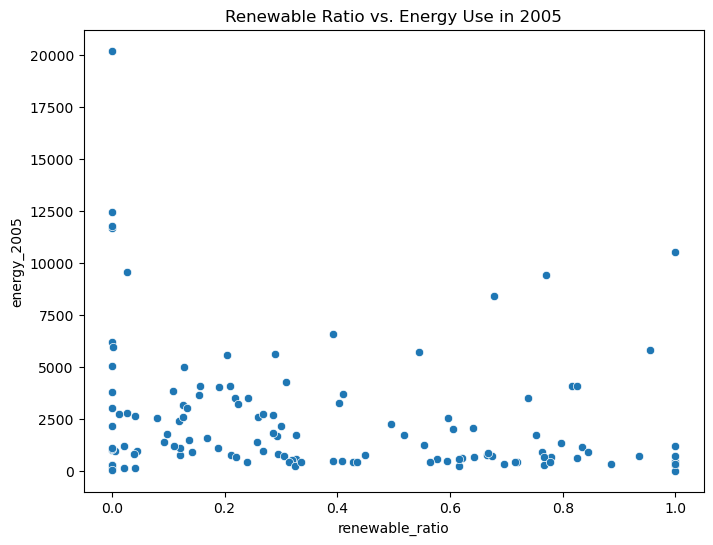

In [18]:

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_analysis,
    x="renewable_ratio",
    y=f"energy_{chosen_year}"
)
plt.title(f"Renewable Ratio vs. Energy Use in {chosen_year}")
plt.show()

In [19]:
df_multi = pd.read_sql_query("""
WITH energy AS (
    SELECT 
        country,
        "2005 [YR2005]" AS energy_2005
    FROM world_bank
    WHERE [Series Name] = 'Energy use (kg of oil equivalent per capita)'
),
gdp AS (
    SELECT 
        country,
        "2005 [YR2005]" AS gdp_2005
    FROM world_bank
    WHERE [Series Name] = 'GDP (current US$)'
),
pop AS (
    SELECT
        country,
        "2005 [YR2005]" AS pop_2005
    FROM world_bank
    WHERE [Series Name] = 'Population, total'
)

SELECT
   cc.country,
   cc.total_renewable_capacity,
   cc.total_capacity,
   energy.energy_2005,
   gdp.gdp_2005,
   pop.pop_2005
FROM country_capacity cc
LEFT JOIN energy ON cc.country = energy.country
LEFT JOIN gdp    ON cc.country = gdp.country
LEFT JOIN pop    ON cc.country = pop.country
;
""", conn)



print(df_multi.head(20))

                   country  total_renewable_capacity  total_capacity  \
0              Afghanistan                 258.55000       300.55000   
1                  Albania                1431.00000      1529.00000   
2                  Algeria                 694.80000     15873.80000   
3                   Angola                 770.60000      1071.18000   
4               Antarctica                   1.00000         7.60000   
5                Argentina               10727.09000     32913.07900   
6                  Armenia                 965.00000      3271.00000   
7                Australia               19009.10000     65852.01600   
8                  Austria                9160.10000     11227.10000   
9               Azerbaijan                 974.00000      5764.00000   
10                 Bahrain                   5.00000      7586.30000   
11              Bangladesh                 263.00000     11840.00000   
12                 Belarus                 232.90000      8534.9

In [20]:
df_multi["energy_2005"] = pd.to_numeric(df_multi["energy_2005"], errors="coerce")
df_multi["gdp_2005"] = pd.to_numeric(df_multi["gdp_2005"], errors="coerce")
df_multi["pop_2005"] = pd.to_numeric(df_multi["pop_2005"], errors="coerce")

df_multi["renewable_ratio"] = df_multi["total_renewable_capacity"] / df_multi["total_capacity"]

df_multi.head(20)

,country,total_renewable_capacity,total_capacity,energy_2005,gdp_2005,pop_2005,renewable_ratio
0,Afghanistan,258.55000,300.55000,NaN,6.203257e+09,NaN,0.860256
1,Albania,1431.00000,1529.00000,719.584378,8.052077e+09,NaN,0.935906
2,Algeria,694.80000,15873.80000,979.149603,1.070466e+11,NaN,0.043770
3,Angola,770.60000,1071.18000,436.773919,3.697090e+10,NaN,0.719394
4,Antarctica,1.00000,7.60000,NaN,NaN,NaN,0.131579
5,Argentina,10727.09000,32913.07900,1706.464137,1.987371e+11,NaN,0.325922
6,Armenia,965.00000,3271.00000,798.470633,4.900470e+09,NaN,0.295017
7,Australia,19009.10000,65852.01600,5624.192019,6.956929e+11,NaN,0.288664
8,Austria,9160.10000,11227.10000,4085.567651,3.139523e+11,NaN,0.815892
9,Azerbaijan,974.00000,5764.00000,1599.960676,1.324542e+10,NaN,0.168980


In [24]:

df_multi.drop(columns=["pop_2005"], inplace=True, errors="ignore")
df_reg = df_multi.dropna(subset=["energy_2005", "renewable_ratio", "gdp_2005"]).copy()
print("Number of rows with all valid data:", len(df_reg))


X = df_reg[["renewable_ratio","gdp_2005"]]
y = df_reg["energy_2005"]

# Add constant for intercept
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

Number of rows with all valid data: 125
                            OLS Regression Results                            
Dep. Variable:            energy_2005   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     4.108
Date:                Sun, 23 Feb 2025   Prob (F-statistic):             0.0188
Time:                        14:20:24   Log-Likelihood:                -1175.0
No. Observations:                 125   AIC:                             2356.
Df Residuals:                     122   BIC:                             2365.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
co

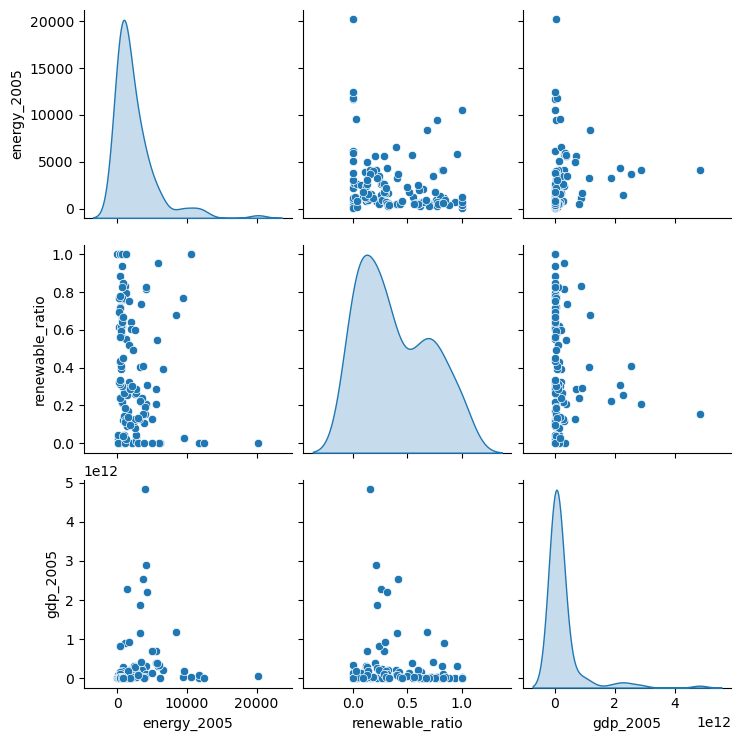

In [25]:
df_plot = df_reg[["energy_2005", "renewable_ratio", "gdp_2005"]]

sns.pairplot(df_plot, diag_kind="kde")
plt.show()

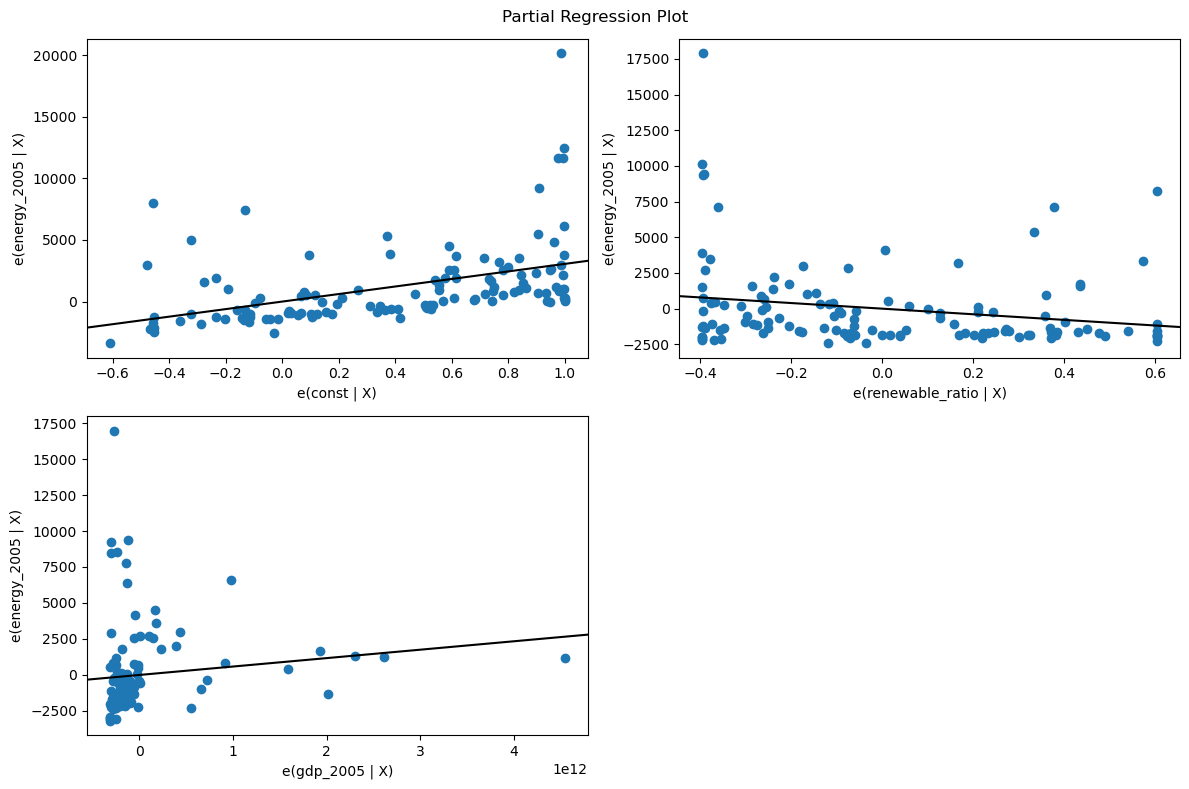

In [27]:
fig = plt.figure(figsize=(12,8))
smg.plot_partregress_grid(model, fig=fig)
plt.tight_layout()
plt.show()